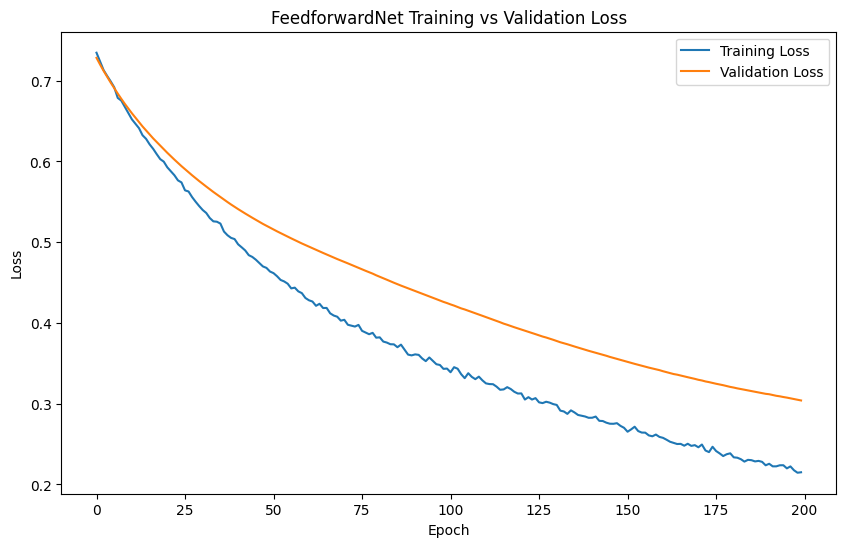

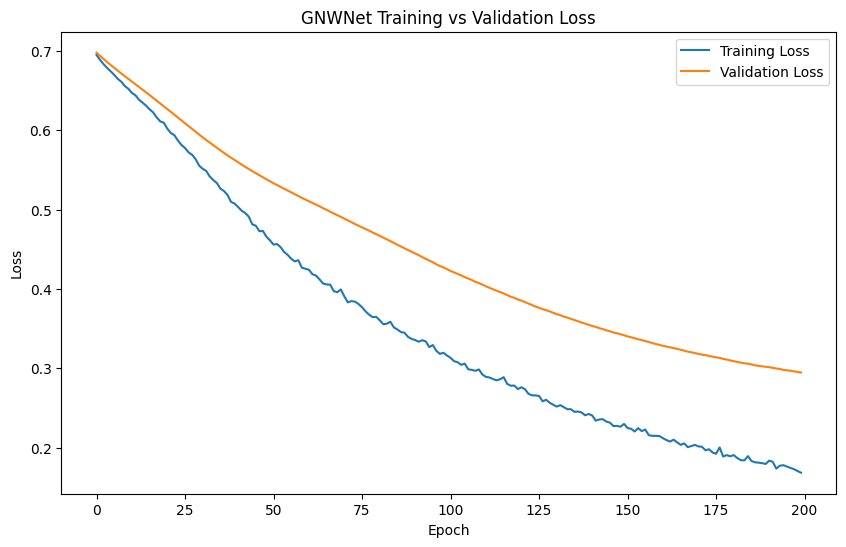

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set fixed random seed 
torch.manual_seed(0)
np.random.seed(0)

# Generate a synthetic classification dataset with 1000 samples, 20 features, 2 classes, and 15 informative features
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, n_informative=17, random_state=42)
# Split the dataset into training and testing sets with 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

noise_factor = 0.5  # Define the magnitude of the noise
noise = np.random.randn(*X_train.shape) * noise_factor  # Generate Gaussian noise
X_train = X_train + noise  # Add noise to the training data

# Initialize the standard scaler
scaler = StandardScaler()
# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)
# Transform the test data with the same scaler
X_test = scaler.transform(X_test)

# Convert arrays into PyTorch tensors for training and testing sets
X_train_torch = torch.FloatTensor(X_train)
X_test_torch = torch.FloatTensor(X_test)
y_train_torch = torch.LongTensor(y_train)
y_test_torch = torch.LongTensor(y_test)

# Create TensorDataset from tensors
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

# Create DataLoader for both training and testing datasets to iterate over batches
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

class FeedforwardNet(nn.Module):
    def __init__(self):
        super(FeedforwardNet, self).__init__()
        self.fc1 = nn.Linear(20, 64)  
        self.relu = nn.ReLU()         
        self.fc2 = nn.Linear(64, 2)  

    def forward(self, x):
        x = self.fc1(x)      
        x = self.relu(x)    
        x = self.fc2(x)      
        return x


class GNWNet(nn.Module):
    def __init__(self):
        super(GNWNet, self).__init__()
        self.fc1 = nn.Linear(20, 64) 
        self.attention = nn.Linear(64, 64)  
        self.relu = nn.ReLU() 
        self.fc2 = nn.Linear(64, 2)  
    
    def forward(self, x):
        x = self.fc1(x)  
        attention_weights = torch.sigmoid(self.attention(x))  
        x = x * attention_weights  
        x = self.relu(x)  
        x = self.fc2(x)  
        return x  

def train_model(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    return average_loss

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    average_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    return average_loss, accuracy

# Lists to store per-epoch data
losses_basic_train = []
losses_gnw_train = []
losses_basic_val = []
losses_gnw_val = []
accuracy_basic_net = []
accuracy_gnw_net = []

basic_net = FeedforwardNet()
gnw_net = GNWNet()
criterion = nn.CrossEntropyLoss()
optimizer_basic = optim.Adam(basic_net.parameters(), lr=0.0001)
optimizer_gnw = optim.Adam(gnw_net.parameters(), lr=0.0001)

# Training and validation for FeedforwardNet
for epoch in range(200):
    train_loss = train_model(basic_net, train_loader, criterion, optimizer_basic)
    val_loss, accuracy = evaluate_model(basic_net, test_loader, criterion)
    losses_basic_train.append(train_loss)
    losses_basic_val.append(val_loss)
    accuracy_basic_net.append(accuracy)

# Training and validation for GNWNet
for epoch in range(200):
    train_loss = train_model(gnw_net, train_loader, criterion, optimizer_gnw)
    val_loss, accuracy = evaluate_model(gnw_net, test_loader, criterion)
    losses_gnw_train.append(train_loss)
    losses_gnw_val.append(val_loss)
    accuracy_gnw_net.append(accuracy)

# Plot for FeedforwardNet
plt.figure(figsize=(10, 6))
plt.plot(losses_basic_train, label='Training Loss')
plt.plot(losses_basic_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FeedforwardNet Training vs Validation Loss')
plt.legend()
plt.show()

# Plot for GNWNet
plt.figure(figsize=(10, 6))
plt.plot(losses_gnw_train, label='Training Loss')
plt.plot(losses_gnw_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GNWNet Training vs Validation Loss')
plt.legend()
plt.show()